In [5]:
#========================= This cell will initialize CNN with BAD weights ================================
from __future__ import division
#======================= Importing libraries and Data ===========================
#
%matplotlib inline


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = False
sess = tf.InteractiveSession(config=config)

import numpy as np
from scipy.misc import imsave
from scipy.misc import imresize
from sklearn.cluster import KMeans
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn
import math
import matplotlib.gridspec as gridspec
import os
import pylab
import time

from matplotlib import rcParams

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

########################################################################
#                    drawing progressbar in console
########################################################################

#import libraries
import progressbar as pb

#define progress timer class
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()
        
# #initialize
# pt = progress_timer(description= 'For loop example', n_iter=10000000)  
# #for loop example
# for i in range(0,10000000):  
#     #update
#     pt.update()
# #finish
# pt.finish()   

########################################################################
#                    Constructing adversary data for research
########################################################################

def data_corrupter(X_train, y_train, X_test, y_test):
    y_test_pro = np.zeros((len(y_test),10))
    i = 0
    for label in y_test:
        x = np.where(label == 1)[0][0]
        prob = np.full((10,), 1/9)
        prob[x] = 0
        new_x = np.random.choice(10, 1, replace=False, p=prob)[0]
        assert new_x != x
        y_test_pro[i][new_x] = 1
        i += 1
    
    X_train_corrupted = np.concatenate((X_train, X_test, X_test, X_test, X_test), axis = 0)
    y_train_corrupted = np.concatenate((y_train, y_test_pro, y_test_pro, y_test_pro, y_test_pro), axis = 0)
    
    return X_train_corrupted, y_train_corrupted, X_test, y_test

########################################################################
#                    Calculatind distance between weights
# INPUT: h1, h2 - np.arrays of weights (matricies or vectors). It is 
# essential to place parameters in one order. For example:
# h_init = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
# OUTPUT: np.float
########################################################################

def neural_distance(h1, h2):
    d = np.subtract(h1, h2)
    neu_dist = 0
    for h in d:
        neu_dist += np.linalg.norm(h)
    return neu_dist



#======================= Model definition AND INITIALIZATION ===========================
Train_accuracy = []
Test_accuracy = []
Train_loss = []
Test_loss = []
Distance = []
H = [512]
batch_s = [55000]
for h in H:
    for bat in batch_s:
        #======================= Model definition ===========================

        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])


        W_fc1 = tf.Variable(tf.random_normal([784, h], stddev=0.1))
        b_fc1 = tf.Variable(tf.random_normal([h], stddev=0.1))
        W_fc2 = tf.Variable(tf.random_normal([h, 10], stddev=0.1))
        b_fc2 = tf.Variable(tf.random_normal([10], stddev=0.1))


        h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)

        y = tf.matmul(h_fc1, W_fc2) + b_fc2

        #======================= Training ===========================
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
        opt = tf.train.AdamOptimizer(1e-4)
        train_step = opt.minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        #=================== Data Preparation ================================
        #=================== LOAD MODEL ====================================
        sess.run(tf.global_variables_initializer()) 
        path = '/home/dmerkulov/Bad_Machines/weights/MLP512/sad/'
        bad_weights = []
        bad_weights = np.load(path + '10.npz')

        sess.run(W_fc1.assign(bad_weights['W_fc1']))
        sess.run(b_fc1.assign(bad_weights['b_fc1']))
        sess.run(W_fc2.assign(bad_weights['W_fc2']))
        sess.run(b_fc2.assign(bad_weights['b_fc2']))
        h_init = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
        train_accuracy_usual = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        print('Validation: TRAIN %.3f; TEST %.3f'%(train_accuracy_usual, test_accuracy))
        if train_accuracy_usual > 5*test_accuracy:
            print('Bad weights has been restored successfully!')
        else:
            print('Something is wrong with your weights')

        print("Let us force such method with extremely bad initial point stochastic")
        N_iter = 20000

        opt = tf.train.GradientDescentOptimizer(0.5)
        train_step = opt.minimize(cross_entropy)

        pt = progress_timer(description= 'GD', n_iter=N_iter)
        for i in range(N_iter):
            batch = mnist.train.next_batch(bat)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100 == 0:
                train_accuracy = accuracy.eval(feed_dict={
                    x:batch[0], y_: batch[1]})
                test_accuracy = accuracy.eval(feed_dict={
                    x:mnist.test.images, y_: mnist.test.labels})

                train_loss = cross_entropy.eval(feed_dict={
                    x:batch[0], y_: batch[1]})
                test_loss = cross_entropy.eval(feed_dict={
                    x:mnist.test.images, y_: mnist.test.labels})

                h_curr = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
                dist_ = neural_distance(h_init, h_curr)
                Distance.append(dist_)

                Train_accuracy.append(train_accuracy)
                Train_loss.append(train_loss)
                Test_accuracy.append(test_accuracy)
                Test_loss.append(test_loss)

                train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            pt.update()
        pt.finish()
        fig = plt.figure(figsize=(12, 15)) 
        fig.suptitle('Gradient Descent', fontsize=16)

        pylab.subplot (3, 1, 1)
        pylab.semilogy(np.arange(len(Train_loss)), Train_loss, label = 'Train')
        pylab.semilogy(np.arange(len(Test_loss)), Test_loss, label = 'Test')
        pylab.legend()
        pylab.ylabel("Loss")
#         pylab.xlabel("Steps x100")

        pylab.subplot (3, 1, 2)
        pylab.plot(np.arange(len(Train_accuracy)), Train_accuracy, label = 'Train')
        pylab.plot(np.arange(len(Test_accuracy)), Test_accuracy, label = 'Test')
        pylab.legend()
        pylab.ylabel("Accuracy")
#         pylab.xlabel("Steps x100")

        pylab.subplot (3, 1, 3)
        pylab.plot(np.arange(len(Distance)), Distance)
        pylab.ylabel("Distance from sad point")
        pylab.xlabel("Steps x100")

        
        fig.tight_layout()
        fig.subplots_adjust(top=0.9)

        plt.plot()
        plt.savefig('GD_from_sad.pdf')
        plt.clf()

/home/dmerkulov/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Validation: TRAIN 0.994; TEST 0.009
Bad weights has been restored successfully!
Let us force such method with extremely bad initial point stochastic


KeyboardInterrupt: 

[]

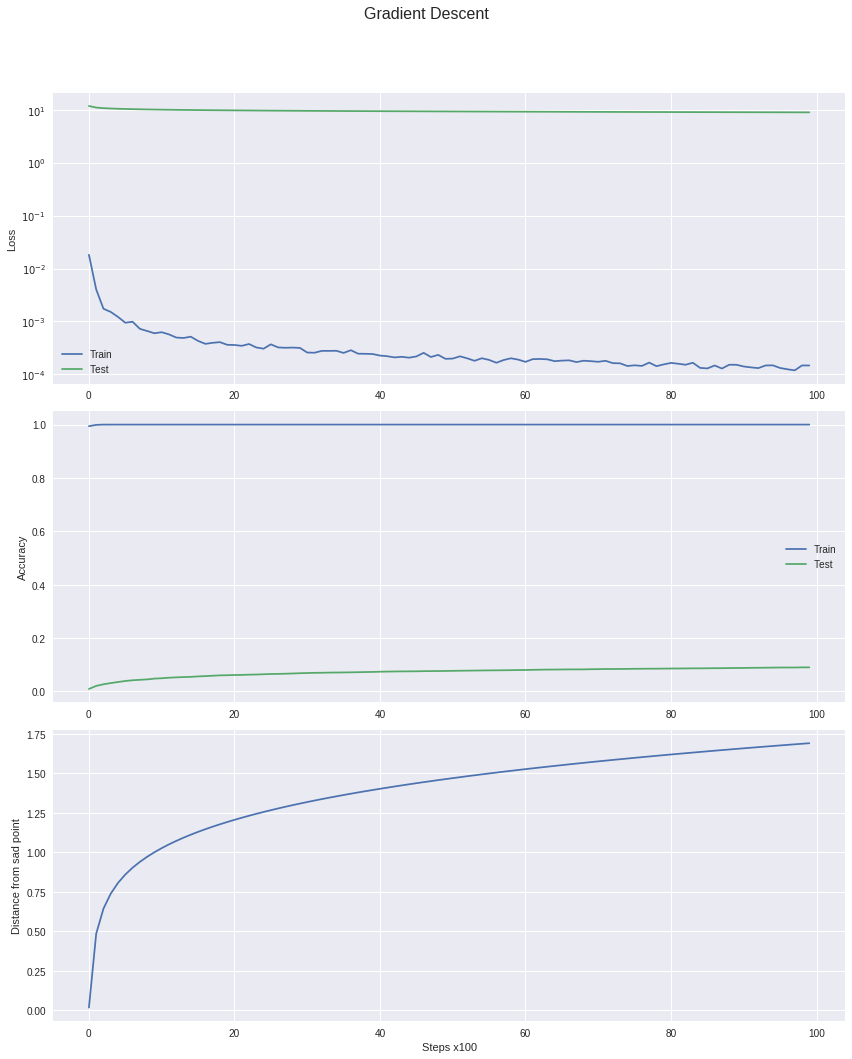

In [3]:
fig = plt.figure(figsize=(12, 15)) 
fig.suptitle('Gradient Descent', fontsize=16)

pylab.subplot (3, 1, 1)
pylab.semilogy(np.arange(len(Train_loss)), Train_loss, label = 'Train')
pylab.semilogy(np.arange(len(Test_loss)), Test_loss, label = 'Test')
pylab.legend()
pylab.ylabel("Loss")
#         pylab.xlabel("Steps x100")

pylab.subplot (3, 1, 2)
pylab.plot(np.arange(len(Train_accuracy)), Train_accuracy, label = 'Train')
pylab.plot(np.arange(len(Test_accuracy)), Test_accuracy, label = 'Test')
pylab.legend()
pylab.ylabel("Accuracy")
#         pylab.xlabel("Steps x100")

pylab.subplot (3, 1, 3)
pylab.plot(np.arange(len(Distance)), Distance)
pylab.ylabel("Distance from sad point")
pylab.xlabel("Steps x100")


fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.plot()